In [2]:
import gym
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from collections import deque
import matplotlib.pyplot as plt

In [3]:
# Define the DQN model
def create_model(state_size, action_size):
    model = Sequential([
        Dense(64, activation="relu", input_shape=(state_size,)),
        Dense(64, activation="relu"),
        Dense(action_size, activation="linear")  # Linear output for Q-values
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4), loss="mse")
    return model

In [4]:
state_size = 8  # State space for LunarLander-v2
action_size = 4  # Action space for LunarLander-v2
BUFFER_SIZE = int(1e5)  # Replay buffer size
BATCH_SIZE = 64  # Minibatch size
GAMMA = 0.99  # Discount factor
TAU = 1e-3  # Soft update parameter for target network
LR = 5e-4  # Learning rate
EPISODES = 1000  # Number of training episodes
MAX_STEPS = 1000  # Maximum steps per episode
EPS_START = 1.0  # Starting epsilon
EPS_END = 0.01  # Minimum epsilon
EPS_DECAY = 0.995  # Epsilon decay rate


In [5]:
class ReplayBuffer:
    def __init__(self, max_size):
        self.buffer = deque(maxlen=max_size)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), size=batch_size, replace=False)
        batch = [self.buffer[i] for i in indices]
        states, actions, rewards, next_states, dones = zip(*batch)
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(dones)

    def __len__(self):
        return len(self.buffer)


In [6]:
import numpy as np
from collections import deque

class ReplayBuffer:
    def __init__(self, max_size):
        self.buffer = deque(maxlen=max_size)

    def add(self, experience):
        """Add a new experience to the buffer."""
        state, action, reward, next_state, done = experience
        self.buffer.append((
            np.asarray(state, dtype=np.float32).flatten(),  # Flatten state for consistent shape
            action,
            reward,
            np.asarray(next_state, dtype=np.float32).flatten(),  # Flatten next_state for consistent shape
            done
        ))

    def sample(self, batch_size):
        """Sample a batch of experiences from the buffer."""
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        batch = [self.buffer[i] for i in indices]

        # Ensure consistent array shapes
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            np.stack(states),         # Stack states for consistent shape
            np.array(actions),        # Convert actions to NumPy array
            np.array(rewards),        # Convert rewards to NumPy array
            np.stack(next_states),    # Stack next states for consistent shape
            np.array(dones)           # Convert dones to NumPy array
        )

    def __len__(self):
        return len(self.buffer)


In [7]:
def epsilon_greedy_policy(state, model, epsilon, action_size):
    if np.random.rand() < epsilon:
        return np.random.randint(action_size)  # Random action
    else:
        Q_values = model.predict(state[np.newaxis], verbose=0)[0]
        return np.argmax(Q_values)  # Optimal action


In [8]:
def soft_update(target_model, local_model, tau):
    for target_var, local_var in zip(target_model.variables, local_model.variables):
        target_var.assign(tau * local_var + (1 - tau) * target_var)


Episode: 1, Reward: -234.93, Epsilon: 0.995

Episode: 2, Reward: -80.94, Epsilon: 0.990

Episode: 9, Reward: -80.47, Epsilon: 0.9561

Episode: 20, Reward: -333.23, Epsilon: 0.905

Episode: 40, Reward: -103.73, Epsilon: 0.818

Episode: 42, Reward: -179.13, Epsilon: 0.810

Episode: 183, Reward: -191.00, Epsilon: 0.400

Episode: 214, Reward: -81.81, Epsilon: 0.3424

Episode: 264, Reward: -93.45, Epsilon: 0.2660

Episode: 335, Reward: -181.20, Epsilon: 0.187

Episode: 346, Reward: -242.00, Epsilon: 0.177

Episode: 963, Reward: 225.84, Epsilon: 0.0100

Episode: 999, Reward: -228.35, Epsilon: 0.010

Episode: 1000, Reward: 250.67, Epsilon: 0.010
Model saved to: saved_model\lunarlander_dqn.h5


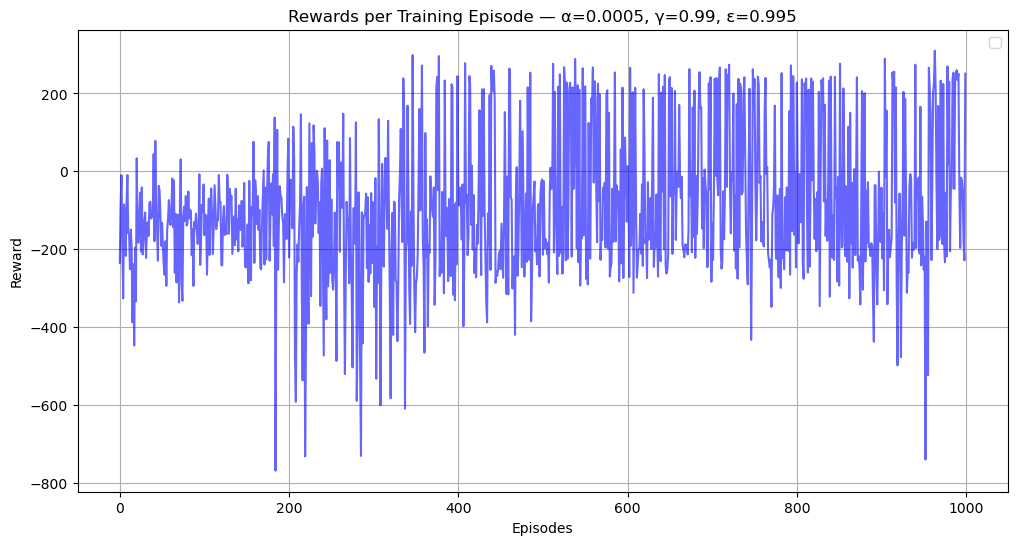

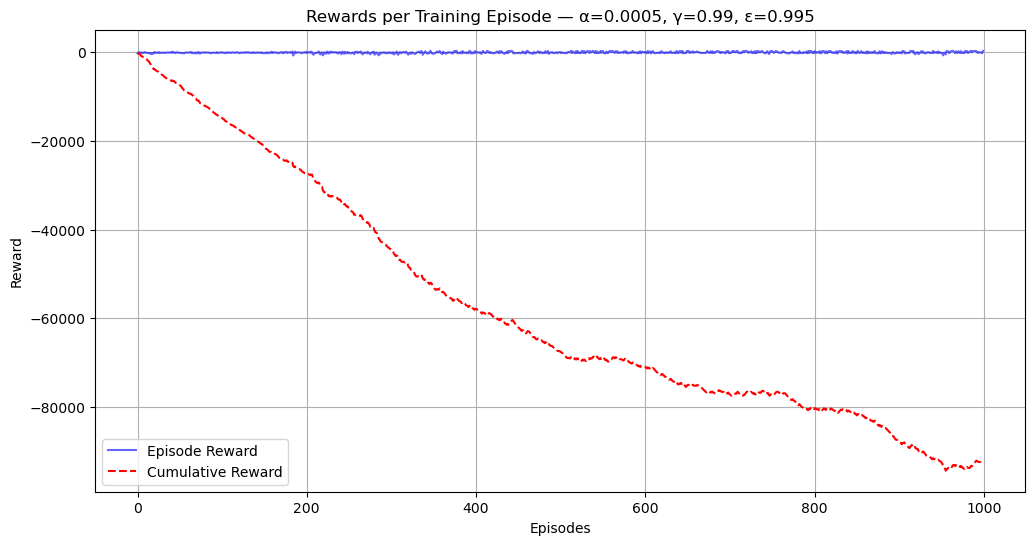

In [11]:

import os

# Directory to save the model
model_dir = "saved_model"
os.makedirs(model_dir, exist_ok=True)

# Initialize environment, models, and replay buffer
env = gym.make("LunarLander-v2")
main_model = create_model(state_size, action_size)
target_model = create_model(state_size, action_size)
target_model.set_weights(main_model.get_weights())
replay_buffer = ReplayBuffer(BUFFER_SIZE)

# Training loop
epsilon = EPS_START
rewards = []
best_reward = -float("inf")  # Track the best reward to save the best model

for episode in range(EPISODES):
    state, _ = env.reset() if isinstance(env.reset(), tuple) else env.reset()  # Handle new Gym API
    total_reward = 0

    for step in range(MAX_STEPS):
        # Select action using epsilon-greedy policy
        action = epsilon_greedy_policy(state, main_model, epsilon, action_size)

        # Take action in the environment
        result = env.step(action)
        if len(result) == 5:  # New Gym API
            next_state, reward, done, truncated, info = result
            done = done or truncated  # Combine `done` and `truncated`
        else:  # Older Gym API
            next_state, reward, done, info = result

        # Store experience in replay buffer
        replay_buffer.add((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward

        # Train the model if enough samples are in the buffer
        if len(replay_buffer) >= BATCH_SIZE:
            states, actions, rewards_batch, next_states, dones = replay_buffer.sample(BATCH_SIZE)

            # Calculate targets
            next_Q_values = target_model.predict(next_states, verbose=0)
            max_next_Q_values = np.amax(next_Q_values, axis=1)
            targets = rewards_batch + (1 - dones) * GAMMA * max_next_Q_values

            # Train main model
            mask = tf.one_hot(actions, action_size)
            with tf.GradientTape() as tape:
                all_Q_values = main_model(states)
                Q_values = tf.reduce_sum(all_Q_values * mask, axis=1)
                loss_fn = tf.keras.losses.MeanSquaredError()
                loss = loss_fn(targets, Q_values)
            grads = tape.gradient(loss, main_model.trainable_variables)
            main_model.optimizer.apply_gradients(zip(grads, main_model.trainable_variables))

        if done:
            break

    # Update target model using soft updates
    soft_update(target_model, main_model, TAU)

    # Update epsilon for the epsilon-greedy policy
    epsilon = max(EPS_END, EPS_DECAY * epsilon)
    rewards.append(total_reward)
    # Saving the best model
    if total_reward > best_reward:
        best_reward = total_reward
        model_path = os.path.join(model_dir, "lunarlander_dqn.h5")
        main_model.save(model_path)  # Saving the model in the specified directory
    print(f"\rEpisode: {episode + 1}, Reward: {total_reward:.2f}, Epsilon: {epsilon:.3f}", end="")

# Printing the model save location
print(f"\nModel saved to: {model_path}")

# Save the best model
main_model.save("lunarlander_dqn.h5")


# Plot rewards
plt.figure(figsize=(12, 6))
plt.legend()
plt.plot(rewards, label='Episode Reward', color='blue', alpha=0.6)
plt.title(f"Rewards per Training Episode — α={LR}, γ={GAMMA}, ε={EPS_DECAY}")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.grid(True)
plt.show()


# Calculate cumulative rewards
import numpy as np
cumulative_rewards = np.cumsum(rewards)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(rewards, label='Episode Reward', color='blue', alpha=0.6)
plt.plot(cumulative_rewards, label='Cumulative Reward', color='red', linestyle='--', linewidth=1.5)
plt.title(f"Rewards per Training Episode — α={LR}, γ={GAMMA}, ε={EPS_DECAY}")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.legend()
plt.grid(True)
plt.show()

In [28]:
import gym
import numpy as np
from tensorflow.keras.models import load_model
import base64
import glob
import io
import os
from gym.wrappers.record_video import RecordVideo
from IPython.display import HTML, display

# Function to display the video with reduced playback speed
def show_video_slow(video_path, playback_speed=0.5):
    video = io.open(video_path, 'r+b').read()
    encoded = base64.b64encode(video)
    display(HTML(data=f'''
        <video alt="test" autoplay loop controls style="height: 400px;">
            <source src="data:video/mp4;base64,{encoded.decode('ascii')}" type="video/mp4" />
        </video>
        <script>
            const videos = document.getElementsByTagName('video');
            for (const video of videos) {{
                video.playbackRate = {playback_speed};
            }}
        </script>
    '''))

# Function to record the agent's interaction with the environment
def record_agent_interaction(model, env_name, video_dir="video"):
    os.makedirs(video_dir, exist_ok=True)  # Ensure the video directory exists
    env = gym.make(env_name, render_mode="rgb_array")
    env = RecordVideo(env, video_folder=video_dir, episode_trigger=lambda x: True)

    state, _ = env.reset(seed=42) if isinstance(env.reset(), tuple) else env.reset()
    done = False

    while not done:
        # Predict the action using the trained model
        action = np.argmax(model.predict(state[np.newaxis], verbose=0))

        # Step through the environment
        result = env.step(action)
        if len(result) == 5:  # Handle new Gym API
            next_state, reward, done, truncated, info = result
            done = done or truncated
        else:
            next_state, reward, done, info = result

        state = next_state

    env.close()
    print("Recording completed.")

# Record and display the video
env_name = "LunarLander-v2"
record_agent_interaction(main_model, env_name)
video_path = glob.glob("video/*.mp4")[0]  # Get the path to the recorded video
show_video_slow(video_path, playback_speed=0.5)  # Display the video at 0.5x speed

MoviePy - Building video C:\Users\bless\video\rl-video-episode-0.mp4.
MoviePy - Writing video C:\Users\bless\video\rl-video-episode-0.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\bless\video\rl-video-episode-0.mp4
Recording completed.


In [29]:
import base64
import glob
import io
import os
from gym.wrappers.record_video import RecordVideo
from IPython.display import HTML, display
import gym
import numpy as np

# Function to display the video with reduced speed
def display_video_slow(video_path, playback_speed=0.5):
    video = io.open(video_path, 'r+b').read()
    encoded = base64.b64encode(video)
    display(HTML(data=f'''
        <video alt="test" autoplay loop controls style="height: 400px;">
            <source src="data:video/mp4;base64,{encoded.decode('ascii')}" type="video/mp4" />
        </video>
        <script>
            const videos = document.getElementsByTagName('video');
            for (const video of videos) {{
                video.playbackRate = {playback_speed};
            }}
        </script>
    '''))

# Function to record a successful episode
def record_successful_landing(model, env_name, reward_threshold=200):
    os.makedirs("video", exist_ok=True)  # Ensure the video directory exists
    env = gym.make(env_name, render_mode="rgb_array")
    env = RecordVideo(env, "video", episode_trigger=lambda x: True)

    successful_episode = False
    while not successful_episode:
        state, _ = env.reset() if isinstance(env.reset(), tuple) else env.reset()
        total_reward = 0
        done = False

        while not done:
            action = np.argmax(model.predict(state[np.newaxis], verbose=0))  # Predict action
            result = env.step(action)
            if len(result) == 5:  # Handle new Gym API
                next_state, reward, done, truncated, info = result
                done = done or truncated
            else:
                next_state, reward, done, info = result

            # Reward shaping for central landing
            if abs(state[0]) < 0.1:
                reward += 10
            if abs(state[1]) < 0.1:
                reward += 10

            total_reward += reward
            state = next_state

        # Check if the agent landed safely with a reward above the threshold
        if total_reward >= reward_threshold:
            successful_episode = True
            print(f"Successful landing recorded with total reward: {total_reward}")
        else:
            print(f"Retrying... Last episode reward: {total_reward}")

    env.close()

# Record and display a successful landing
record_successful_landing(main_model, "LunarLander-v2", reward_threshold=200)

# Find and display the video
video_path = glob.glob("video/*.mp4")[0]  # Find the first video in the folder
display_video_slow(video_path, playback_speed=0.1)  # Display the video at 0.1x speed


MoviePy - Building video C:\Users\bless\video\rl-video-episode-0.mp4.
MoviePy - Writing video C:\Users\bless\video\rl-video-episode-0.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\bless\video\rl-video-episode-0.mp4
Successful landing recorded with total reward: 2472.0451363928782


In [18]:
import gym
import numpy as np
from tensorflow.keras.models import load_model
import base64
import io
import os
from gym.wrappers import RecordVideo
from IPython.display import HTML, display

# Load the trained model without compilation
model_path = "saved_model/lunarlander_dqn.h5"
main_model = load_model(model_path, compile=False)  # Skip compilation during loading

# Function to display the video
def show_video(video_path):
    video = io.open(video_path, 'r+b').read()
    encoded = base64.b64encode(video)
    display(HTML(data=f'''
        <video alt="test" autoplay loop controls style="height: 400px;">
            <source src="data:video/mp4;base64,{encoded.decode('ascii')}" type="video/mp4" />
        </video>'''))

# Function to run the trained agent and record its interaction with the environment
def record_agent_interaction(model, env_name, video_dir="video"):
    os.makedirs(video_dir, exist_ok=True)  # Ensure the video directory exists
    env = gym.make(env_name, render_mode="rgb_array")
    env = RecordVideo(env, video_folder=video_dir, episode_trigger=lambda x: True)

    state, _ = env.reset()
    total_reward = 0
    done = False

    while not done:
        # Agent selects an action
        action = np.argmax(model.predict(state[np.newaxis], verbose=0))  # Predict action
        result = env.step(action)
        if len(result) == 5:  # Handle new Gym API
            next_state, reward, done, truncated, info = result
            done = done or truncated
        else:
            next_state, reward, done, info = result

        total_reward += reward
        state = next_state

    print(f"Total Reward: {total_reward}")
    env.close()

# Record and display video
env_name = "LunarLander-v2"
video_dir = "video"
record_agent_interaction(main_model, env_name, video_dir)

# Find and display the video
video_path = [file for file in os.listdir(video_dir) if file.endswith(".mp4")][0]
show_video(os.path.join(video_dir, video_path))


MoviePy - Building video C:\Users\bless\video\rl-video-episode-0.mp4.
MoviePy - Writing video C:\Users\bless\video\rl-video-episode-0.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\bless\video\rl-video-episode-0.mp4
Total Reward: 212.3376999511501
